# Example to connect to postgres

This is a tutorial to connect to our PostgreSQL database using python.

First you need to install the following libraries:
- psycopg2
- python-dotenv

Then you need to create a file with the name ".env". This file will contain the connection information and your credentials. This is an example:

```
DB_HOST=host_name
DB_NAME=postgres
DB_USER=my_user
DB_PASSWORD=my_password
DB_PORT=5432
```

After that you´re all set. We will import your credentials and connect to the database.

In [129]:
import os
import psycopg2 # PostgreSQL database adapter for Python
from dotenv import load_dotenv # Reads the key-value pair from .env file and adds them to environment variable

# Load environment variables from .env file
load_dotenv()

# Accessing credentials
db_host = os.getenv("DB_HOST")
db_name = os.getenv("DB_NAME")
db_user = os.getenv("DB_USER")
db_password = os.getenv("DB_PASSWORD")
db_port = os.getenv("DB_PORT")

In [130]:
# Connect to the database
conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
)

Now we can query our data (write sql code) and store it as a pandas dataframe

In [173]:
import pandas as pd
from sklearn.metrics import mean_squared_error

In [204]:
query="""
    select * 
    from agg.t_msb1m  
    where year = 2019 and site=84 and month =6 and min = 0
"""

In [205]:
df = pd.read_sql_query(query, conn)

C:\Users\xlow6\AppData\Local\Temp\ipykernel_2664\1553155693.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   site              720 non-null    int64  
 1   year              720 non-null    int64  
 2   month             720 non-null    int64  
 3   day               720 non-null    int64  
 4   hour              720 non-null    int64  
 5   min               720 non-null    int64  
 6   tz                720 non-null    object 
 7   soc               720 non-null    float64
 8   discharge_wh      720 non-null    float64
 9   charge_wh         720 non-null    float64
 10  production_wh     720 non-null    float64
 11  consumption_wh    720 non-null    float64
 12  gridexport_wh     720 non-null    float64
 13  gridimport_wh     720 non-null    float64
 14  pvcharge_wh       720 non-null    float64
 15  pvcons_wh         720 non-null    float64
 16  pvexport_wh       720 non-null    float64
 1

In [207]:
df = df.rename(columns={'min': 'minute'})
df['datetime'] = pd.to_datetime(df[['year','month', 'day', 'hour','minute']])
df['net_load'] = df['consumption_wh'] + df['charge_wh'] - df['discharge_wh'] - df['production_wh']


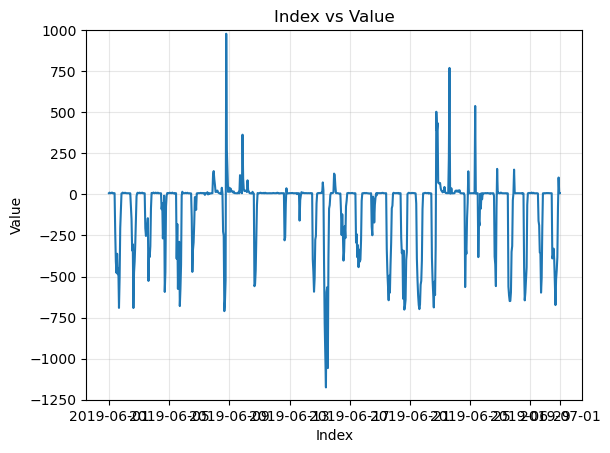

In [208]:
import matplotlib.pyplot as plt

plt.plot(df['datetime'],df['net_load'])
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Index vs Value')
plt.grid(alpha=0.3) 
plt.ylim(-1250,1000)
plt.show()

(array([18048., 18052., 18056., 18060., 18064., 18068., 18072., 18076.,
        18078.]),
 [Text(18048.0, 0, '2019-06-01'),
  Text(18052.0, 0, '2019-06-05'),
  Text(18056.0, 0, '2019-06-09'),
  Text(18060.0, 0, '2019-06-13'),
  Text(18064.0, 0, '2019-06-17'),
  Text(18068.0, 0, '2019-06-21'),
  Text(18072.0, 0, '2019-06-25'),
  Text(18076.0, 0, '2019-06-29'),
  Text(18078.0, 0, '2019-07-01')])

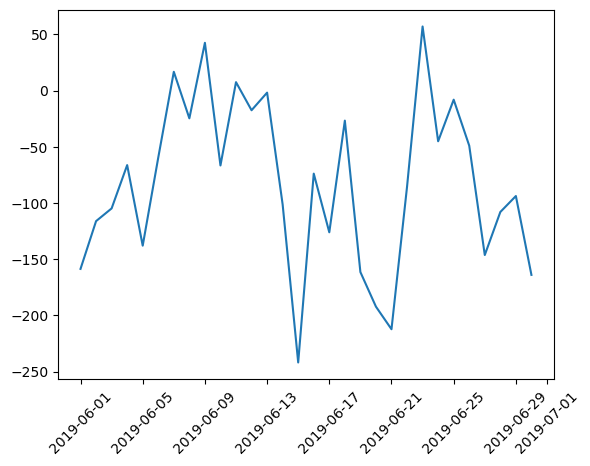

In [209]:
avg_load_day = df.groupby(df['datetime'].dt.date)['net_load'].mean()

plt.plot(avg_load_day)

plt.xticks(rotation=45) 

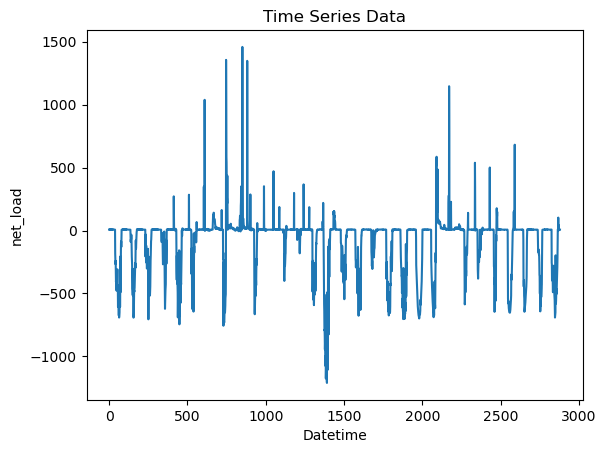

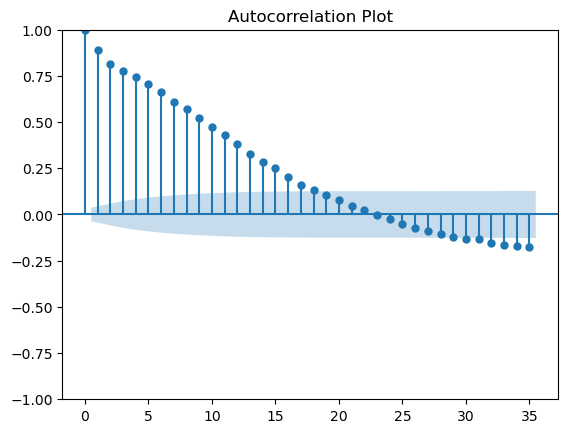

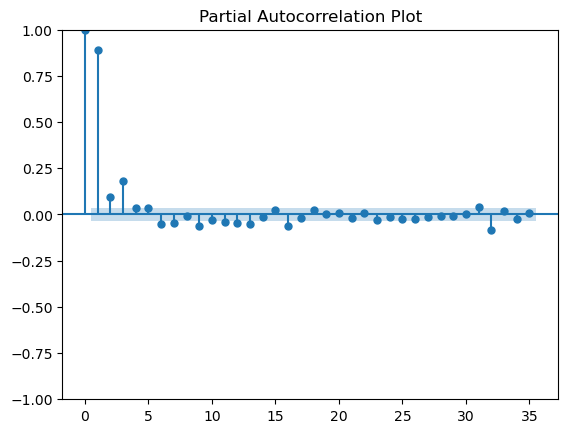

c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:               net_load   No. Observations:                 2880
Model:                ARIMA(20, 1, 7)   Log Likelihood              -17276.616
Date:                Mon, 25 Mar 2024   AIC                          34609.232
Time:                        12:41:55   BIC                          34776.258
Sample:                             0   HQIC                         34669.437
                               - 2880                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4839      1.343     -0.360      0.719      -3.116       2.148
ar.L2         -0.4096      1.292     -0.317      0.751      -2.942       2.123
ar.L3         -0.4014      0.730     -0.550      0.5

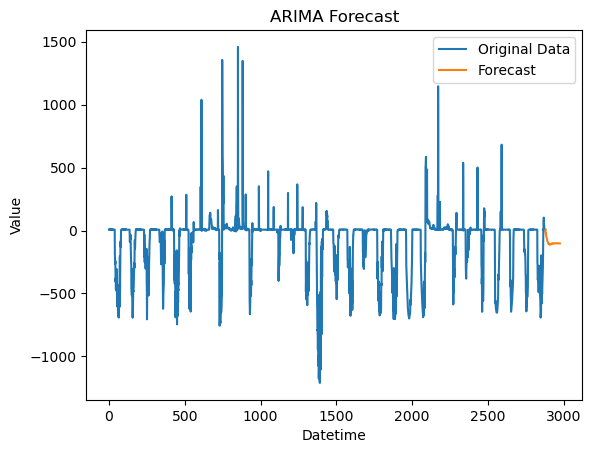

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Assuming 'df' is your DataFrame with datetime index and 'value' column

# Plot the time series data
df['net_load'].plot()
plt.xlabel('Datetime')
plt.ylabel('net_load')
plt.title('Time Series Data')
plt.show()

# Plot autocorrelation and partial autocorrelation plots
plot_acf(df['net_load'])
plt.title('Autocorrelation Plot')
plt.show()

plot_pacf(df['net_load'])
plt.title('Partial Autocorrelation Plot')
plt.show()

# Fit ARIMA model
order = (20, 1, 7)  # Example: ARIMA(2,1,1) model
model = ARIMA(df['net_load'], order=order)
fitted_model = model.fit()

# Summary of the model
print(fitted_model.summary())

# Forecast future values for the next day (96 15-minute intervals)
forecast_steps = 96
forecast = fitted_model.forecast(steps=forecast_steps)

# Generate datetime index for the forecasted values
last_datetime = df.index[-1]
#forecast_index = pd.date_range(start=last_datetime, periods=forecast_steps + 1, freq='15T')[1:]  # Start from the next interval
forecast_index = list(range(2879, 2975))

# Plot the original data and forecasted values
plt.plot(df.index, df['net_load'], label='Original Data')
plt.plot(forecast_index, forecast, label='Forecast')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('ARIMA Forecast')
plt.legend()
plt.show()


c:\Users\xlow6\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Mean Squared Error: 34629.90704603014
Forecasted Values: 503      3.235291
504     -6.119629
505    -14.397067
506    -19.527534
507    -21.803247
508    -23.160781
509    -17.898858
510    -24.897947
511    -45.163140
512    -62.312704
513    -71.561954
514   -137.611482
515   -198.765449
516   -251.895937
517   -318.915497
518   -338.596970
519   -355.156075
520   -389.178843
521   -365.662929
522   -278.975965
523   -114.117140
524    -37.491806
525     -6.087028
526    -18.489753
Name: predicted_mean, dtype: float64


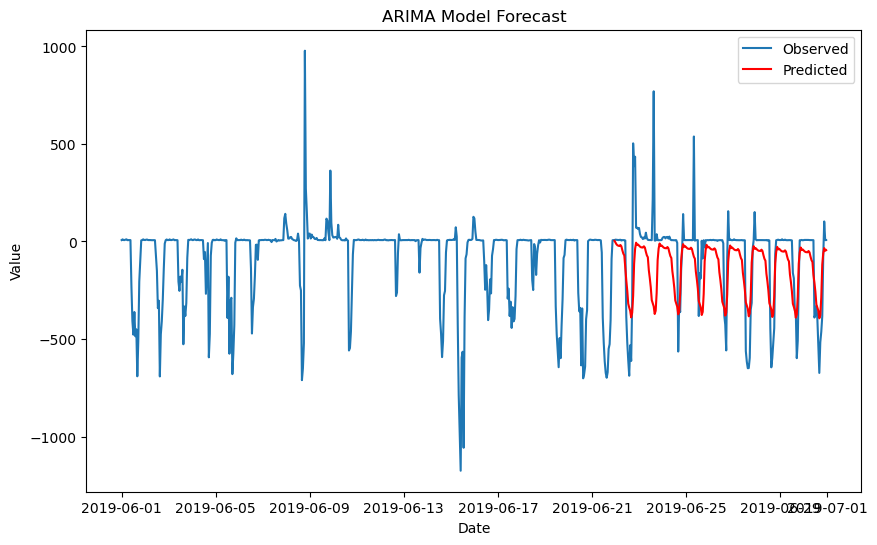

In [213]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
train_size = int(len(df) * 0.9)
train_data, test_data = df[:train_size], df[train_size:]

# Step 6: SARIMA Modeling
# Fit ARIMA model to the training data
model = SARIMAX(train_data['net_load'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))  # Example order, adjust as needed
arima_model = model.fit()

# Step 7: Model Evaluation
# Make predictions on the testing set
predictions = arima_model.predict(start=len(train_data), end=len(train_data)+len(test_data)-1, typ='levels')
mse = mean_squared_error(test_data['net_load'], predictions)
print('Mean Squared Error:', mse)

# Step 8: Forecasting
# Use the trained ARIMA model to forecast future time periods
forecast_horizon = 24
forecast = arima_model.forecast(steps=forecast_horizon)
print('Forecasted Values:', forecast)

plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['net_load'], label='Observed')
plt.plot(test_data['datetime'], predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

c:\Users\xlow6\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0405 - val_loss: 0.0024
Epoch 2/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0029 - val_loss: 0.0023
Epoch 3/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0031 - val_loss: 0.0022
Epoch 4/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0021
Epoch 5/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 6/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 10/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 12/20
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.00

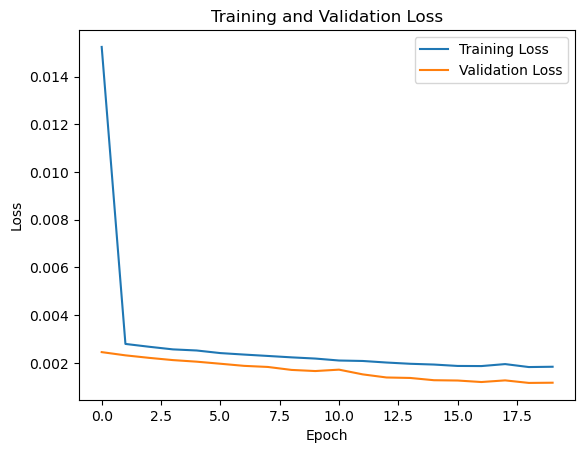

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


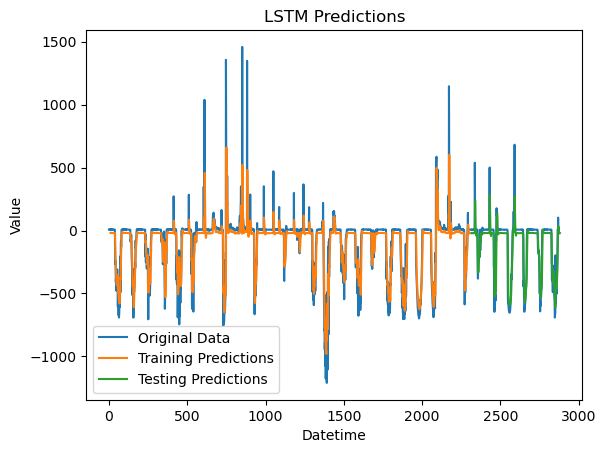

In [128]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

# Preprocess the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['net_load']])

# Split the data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Function to create sequences for LSTM model
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Set sequence length
seq_length = 10  # Example: You may adjust this based on your data

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

# Build LSTM model
model = Sequential([
    LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse scaling
# Inverse scaling
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))  # Flatten and reshape to 2D
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))  # Flatten and reshape to 2D


# Plot predictions
plt.plot(df.index[:-seq_length], df['net_load'][:-seq_length], label='Original Data')
plt.plot(df.index[seq_length:train_size], train_predictions.flatten(), label='Training Predictions')
plt.plot(df.index[train_size+seq_length:], test_predictions.flatten(), label='Testing Predictions')
plt.xlabel('Datetime')
plt.ylabel('Value')
plt.title('LSTM Predictions')
plt.legend()
plt.show()